In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.segmentation import slic
from enum import Enum
from typing import Any, List

In [2]:
pillbox = np.load('images/pillbox.npy')
test = np.load('images/test.npy')
line = np.load('images/line.npy')

pillbox_hough = np.load('images/pillbox_hough.npy')
test_hough = np.load('images/test_hough.npy')
line_hough = np.load('images/line_hough.npy')

pillbox_background = np.load('images/pillbox_background.npy')
test_background = np.load('images/test_background.npy')
line_background = np.load('images/line_background.npy')

In [3]:
get_labels = lambda img: cv2.connectedComponents(img, connectivity = 4)[1]

pillbox_labels = get_labels(pillbox_background)
test_labels = get_labels(test_background)
line_labels = get_labels(line_background)

In [4]:
from scipy.stats import mode

def filter_labels(labels, img):
    flatten_labels = labels.flatten()
    unique_labels = np.array(list(set(labels.flatten())))
    flatten_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY).flatten()
    filtered_labels = []
    
    for label in unique_labels:
        region_mode = mode(flatten_img[flatten_labels == label])[0]
        if region_mode != 0:
            filtered_labels.append(label)
            
    return filtered_labels



def plot_roi(labels, filtered_labels, img):
    
    fig, axs = plt.subplots(4, 4, figsize = (10, 10))
    
    for i, label in enumerate(filtered_labels):
        roi = img.copy()
        roi[labels != label] = 0
        
        axs[i // 4][i % 4].imshow(roi)
        axs[i // 4][i % 4].set_title(f'Label no. {label}')
        axs[i // 4][i % 4].axis('off')
    
    fig.tight_layout()
    plt.show()



def single_roi(img, labels, k):
    roi = img.copy()
    roi[labels != k] = 0
    return roi

In [5]:
pillbox_flabels = filter_labels(pillbox_labels, pillbox)
test_flabels = filter_labels(test_labels, test)
line_flabels = filter_labels(line_labels, line)

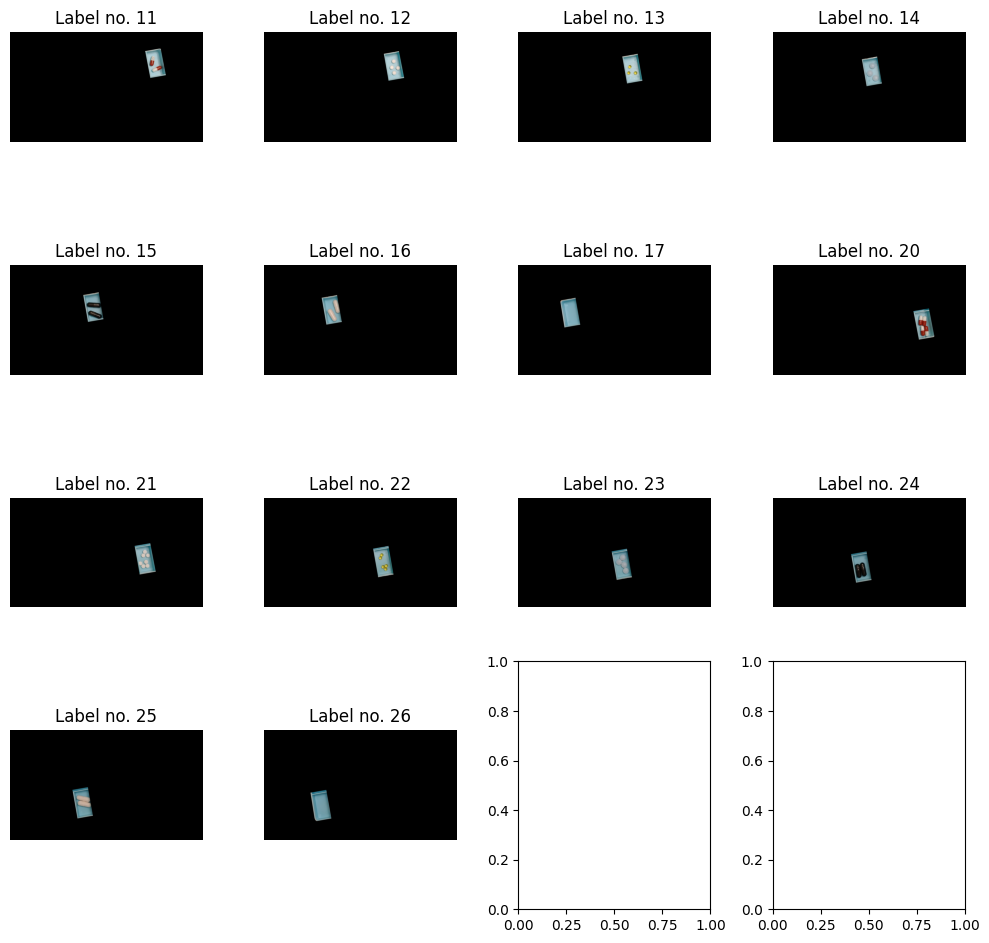

In [6]:
plot_roi(pillbox_labels, pillbox_flabels, pillbox)

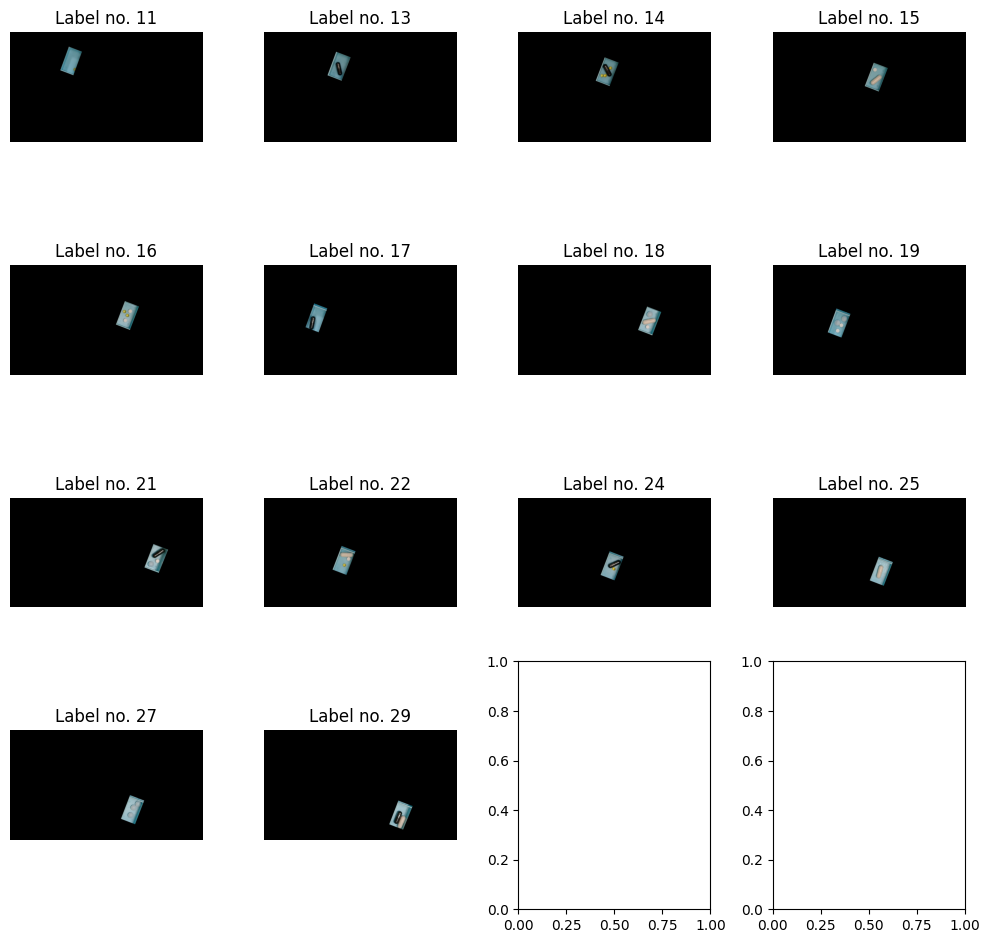

In [7]:
plot_roi(test_labels, test_flabels, test)

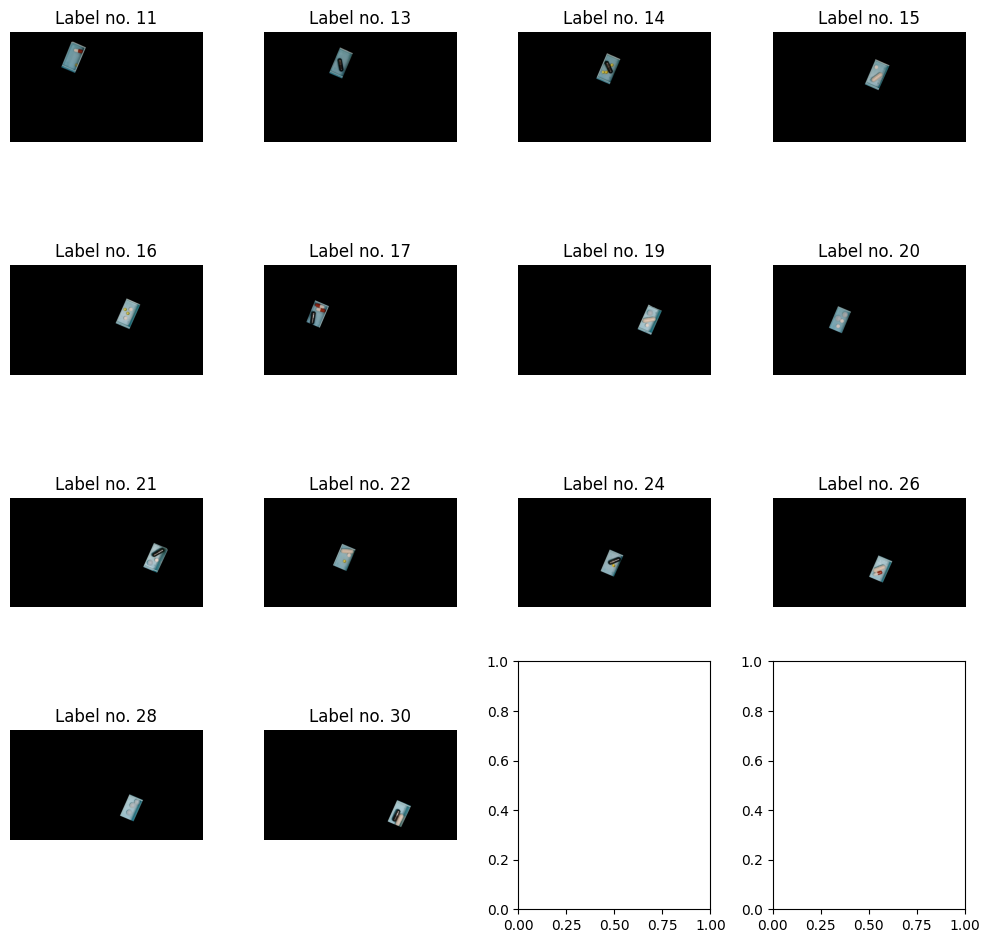

In [8]:
plot_roi(line_labels, line_flabels, line)

In [9]:
def detect_biox(roi, dest_img):
    dest_img = dest_img.copy()
    
    GRAY = roi[..., 0]
    CIRCLES = cv2.HoughCircles(GRAY, cv2.HOUGH_GRADIENT, 1, 20,
                                param1 = 5, param2 = 30,
                                minRadius = 26, maxRadius = 33)

    if CIRCLES is not None:
        CIRCLES = np.uint16(np.around(CIRCLES))
        for i in CIRCLES[0, :]:
            center = (i[0], i[1])
            cv2.circle(dest_img, center, 1, (0, 100, 100), 3)
            radius = i[2]
            cv2.circle(dest_img, center, radius, (255, 0, 255), 3)

    return dest_img

In [10]:
def detect_epsu(roi, dest_img):
    dest_img = dest_img.copy()
    GRAY = cv2.threshold(cv2.cvtColor(roi, cv2.COLOR_RGB2LAB)[..., 2], 167, 255, cv2.THRESH_BINARY)[1]
    CIRCLES = cv2.HoughCircles(GRAY, cv2.HOUGH_GRADIENT, 1, 20,
                                param1 = 30, param2 = 7,
                                minRadius = 3, maxRadius = 25)

    if CIRCLES is not None:
        CIRCLES = np.uint16(np.around(CIRCLES))
        for i in CIRCLES[0, :]:
            center = (i[0], i[1])
            cv2.circle(dest_img, center, 1, (0, 100, 100), 3)
            radius = i[2]
            cv2.circle(dest_img, center, radius, (255, 255, 0), 3)

    return dest_img, CIRCLES

In [11]:
def detect_keto(roi, dest_img):
    dest_img = dest_img.copy()
    GRAY = cv2.cvtColor(roi, cv2.COLOR_RGB2HLS)[..., 2]
    CIRCLES = cv2.HoughCircles(GRAY, cv2.HOUGH_GRADIENT, 1, 25,
                                param1 = 30, param2 = 26,
                                minRadius = 40, maxRadius = 50)

    if CIRCLES is not None:
        CIRCLES = np.uint16(np.around(CIRCLES))
        for i in CIRCLES[0, :]:
            center = (i[0], i[1])
            cv2.circle(dest_img, center, 1, (0, 100, 100), 3)
            radius = i[2]
            cv2.circle(dest_img, center, radius, (0, 0, 255), 3)

    return dest_img

In [12]:
def detect_carbon(dest_img):
    dest_img = dest_img.copy()
    GRAY = cv2.cvtColor(dest_img, cv2.COLOR_RGB2HSV)[..., 2]
    
    _, t = cv2.threshold(GRAY, 45, 255, type = cv2.THRESH_BINARY)
    morph_img = cv2.morphologyEx(t, 
                                 cv2.MORPH_OPEN, 
                                 np.ones((3, 3), np.uint8), 
                                 iterations = 3)
    
    _, labels = cv2.connectedComponents(morph_img, connectivity = 4)
    sizes = np.bincount(labels.ravel())
    box_idx = np.argmax(sizes[1:]) + 1
    shine = morph_img.copy()
    shine[labels == box_idx] = 0
    
    removed_shine = morph_img.copy()
    removed_shine[shine == 255] = 0
    
    _, labels2 = cv2.connectedComponents(~removed_shine, connectivity = 4)
    sizes2 =  np.bincount(labels2.ravel())
    sizess = sizes2[2:]
    labelss = np.array(list(set(list(labels2.flatten())))[2:])
    dct = dict(zip(labelss, sizess))
    filtered_dct = {k: v for k, v in dct.items() if v > 10000}
    
    just_pills = ~removed_shine.copy()
    just_pills[~np.isin(labels2, list(filtered_dct.keys()))] = 0
    
    _, labels3 = cv2.connectedComponents(just_pills, connectivity = 4)

    if max(np.bincount(labels3.ravel())) > 15000:
        lab = cv2.cvtColor(dest_img, cv2.COLOR_RGB2LAB)[..., 2]
        t_lab = cv2.threshold(lab, 130, 255, cv2.THRESH_BINARY)[1]
        erode = just_pills.copy()
        erode[t_lab == 0] = 0
        eroded_pills = cv2.morphologyEx(erode, cv2.MORPH_CLOSE, np.ones((3, 3), np.uint8), iterations = 10)
        _, markers = cv2.connectedComponents(eroded_pills, connectivity= 4)
        
        color_full_image = just_pills.copy()
        cv2.watershed(cv2.merge([color_full_image] * 3), markers)
        color_full_image[markers == -1] = 0
        color_full_image = cv2.erode(color_full_image, kernel = np.ones((3, 3), np.uint8), anchor = (-1, -1), borderType = cv2.BORDER_REPLICATE)
        just_pills = color_full_image.copy()
        
    contours, _ = cv2.findContours(just_pills, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cv2.drawContours(dest_img, contours, -1, (0, 255, 0), 3)
        
    return dest_img

In [13]:
def detect_probio(dest_img, epsu_circles):
    dest_img = dest_img.copy()
    GRAY1 = cv2.threshold(cv2.cvtColor(dest_img, cv2.COLOR_RGB2LAB)[..., 1], 135, 255, cv2.THRESH_BINARY)[1]
    GRAY2 = cv2.threshold(cv2.cvtColor(dest_img, cv2.COLOR_RGB2LAB)[..., 2], 135, 255, cv2.THRESH_BINARY)[1]
    
    for i in epsu_circles[0, :]:
        center = (i[0], i[1])
        radius = i[2]
        cv2.circle(GRAY2, center, radius, (0, 0, 0), -1)
    GRAY2[GRAY1 == 255] = 0

    _, labels = cv2.connectedComponents(GRAY2, connectivity = 4)
    sizes = np.bincount(labels.ravel())
    labelss = np.array(list(set(list(labels.flatten()))))
    dct = dict(zip(labelss, sizes))
    filtered_dct = {k: v for k, v in dct.items() if v > 7000}
    
    just_pills = GRAY2.copy()
    just_pills[~np.isin(labels, list(filtered_dct.keys()))] = 0
    just_pills = cv2.morphologyEx(just_pills, cv2.MORPH_OPEN, np.ones((3, 3), np.uint8), iterations = 5)
    
    contours, _ = cv2.findContours(just_pills, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cv2.drawContours(dest_img, contours, -1, (0, 0, 0), 3)
    
    return dest_img

In [14]:
def squeeze_circles(all_circles):
    return  np.concatenate([x for x in all_circles if x is not None], axis = 1)
    

output = pillbox.copy()
all_circles_biox = []
all_circles_epsu = []
for label in pillbox_flabels:
    roi = single_roi(pillbox, pillbox_labels, label)
    output, circles_epsu = detect_epsu(roi, output)
    all_circles_epsu.append(circles_epsu)
    

ggg = [x for x in all_circles_epsu if x is not None]

comb = np.concatenate((ggg[0], ggg[1]), axis = 1)

In [15]:
def final_test(img, img_background):
    output = img.copy()
    labels = get_labels(img_background)
    flabels = filter_labels(labels, img)
    all_circles = []
    for label in flabels:
        roi = single_roi(img, labels, label)
        output = detect_keto(roi, output)
        output = detect_biox(roi, output)
        output, circles = detect_epsu(roi, output)
        all_circles.append(circles)
    all_circles = squeeze_circles(all_circles)
    output = detect_carbon(output)
    output = detect_probio(output, all_circles)
    
    plt.imshow(output)

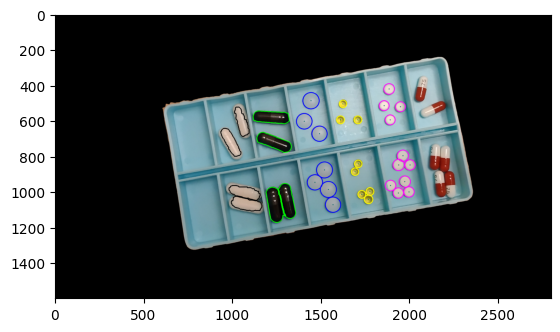

In [16]:
final_test(pillbox, pillbox_background)

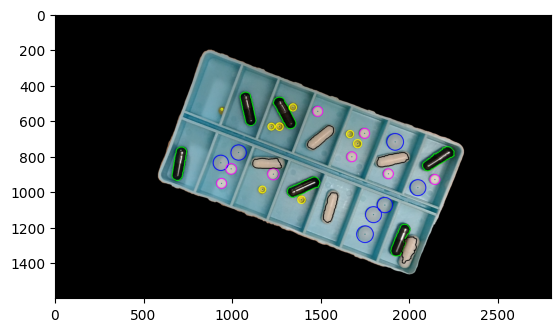

In [18]:
final_test(test, test_background)

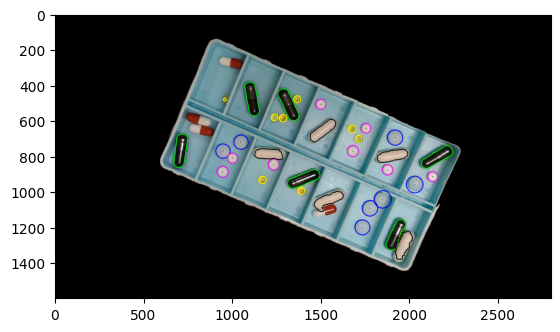

In [19]:
final_test(line, line_background)

# Biała

In [ ]:
def detect_biox(roi, dest_img):
    dest_img = dest_img.copy()
    
    GRAY = roi[..., 0]
    CIRCLES = cv2.HoughCircles(GRAY, cv2.HOUGH_GRADIENT, 1, 20,
                                param1 = 5, param2 = 30,
                                minRadius = 26, maxRadius = 33)

    if CIRCLES is not None:
        CIRCLES = np.uint16(np.around(CIRCLES))
        for i in CIRCLES[0, :]:
            center = (i[0], i[1])
            cv2.circle(dest_img, center, 1, (0, 100, 100), 3)
            radius = i[2]
            cv2.circle(dest_img, center, radius, (255, 0, 255), 3)

    return dest_img, CIRCLES

def detect_epsu(roi, dest_img):
    dest_img = dest_img.copy()
    GRAY = cv2.threshold(cv2.cvtColor(roi, cv2.COLOR_RGB2LAB)[..., 2], 167, 255, cv2.THRESH_BINARY)[1]
    CIRCLES = cv2.HoughCircles(GRAY, cv2.HOUGH_GRADIENT, 1, 20,
                                param1 = 30, param2 = 7,
                                minRadius = 3, maxRadius = 25)

    if CIRCLES is not None:
        CIRCLES = np.uint16(np.around(CIRCLES))
        for i in CIRCLES[0, :]:
            center = (i[0], i[1])
            cv2.circle(dest_img, center, 1, (0, 100, 100), 3)
            radius = i[2]
            cv2.circle(dest_img, center, radius, (255, 255, 0), 3)

    return dest_img, CIRCLES

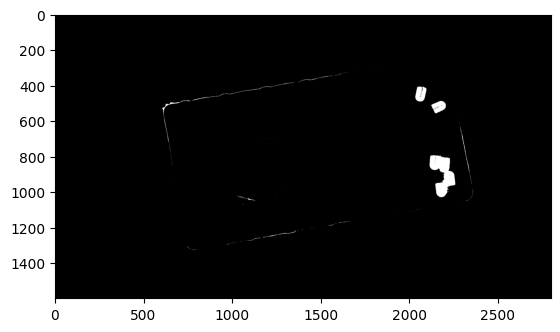

In [ ]:
bbb = cv2.threshold(cv2.cvtColor(pillbox, cv2.COLOR_RGB2LAB)[..., 1], 135, 255, cv2.THRESH_BINARY)[1]
plt.imshow(bbb, cmap = 'gray')

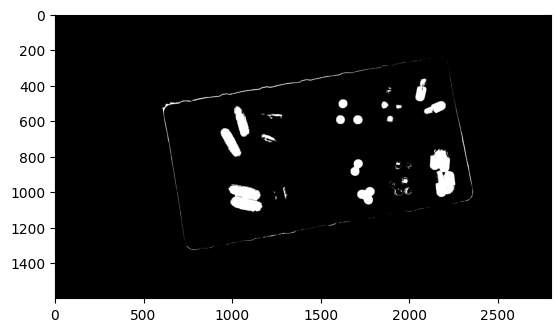

In [ ]:
aaa = cv2.threshold(cv2.cvtColor(pillbox, cv2.COLOR_RGB2LAB)[..., 2], 135, 255, cv2.THRESH_BINARY)[1]
plt.imshow(aaa, cmap = 'gray')

In [ ]:
output = pillbox.copy()
all_circles_biox = []
all_circles_epsu = []
for label in pillbox_flabels:
    roi = single_roi(pillbox, pillbox_labels, label)
    output, circles_epsu = detect_epsu(roi, output)
    all_circles_epsu.append(circles_epsu)

In [ ]:
all_circles_epsu

[None,
 None,
 array([[[1608,  596,   22],
         [1622,  506,   21],
         [1706,  596,   22]]], dtype=uint16),
 None,
 None,
 None,
 None,
 None,
 None,
 array([[[1690,  888,   21],
         [1774, 1000,   22],
         [1766, 1044,   24],
         [1708,  844,   21],
         [1728, 1016,   22]]], dtype=uint16),
 None,
 None,
 None,
 None]

In [ ]:

ggg = [x for x in all_circles_epsu if x is not None]

comb = np.concatenate(ggg, axis = 1)
comb

array([[[1608,  596,   22],
        [1622,  506,   21],
        [1706,  596,   22],
        [1690,  888,   21],
        [1774, 1000,   22],
        [1766, 1044,   24],
        [1708,  844,   21],
        [1728, 1016,   22]]], dtype=uint16)

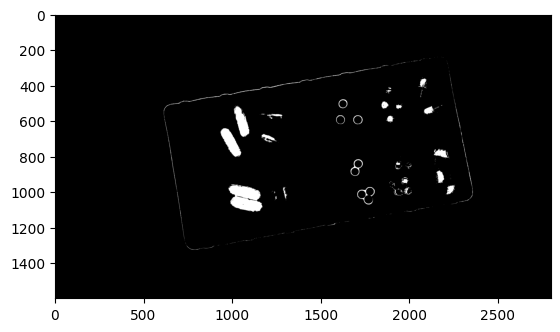

In [ ]:
for i in comb[0, :]:
    center = (i[0], i[1])
    # cv2.circle(dest_img, center, 1, (0, 100, 100), 3)
    radius = i[2]
    cv2.circle(aaa, center, radius, (0, 0, 0), -1)
aaa[bbb == 255] = 0
plt.imshow(aaa, cmap='gray')

In [ ]:
num_labels, labels = cv2.connectedComponents(aaa, connectivity = 4)
sizes = np.bincount(labels.ravel())
labelss = np.array(list(set(list(labels.flatten()))))
dct = dict(zip(labelss, sizes))
filtered_dct = {k: v for k, v in dct.items() if v > 7000}
filtered_dct

{np.int32(0): np.int64(4415092),
 np.int32(136): np.int64(8039),
 np.int32(225): np.int64(8831),
 np.int32(412): np.int64(20254)}

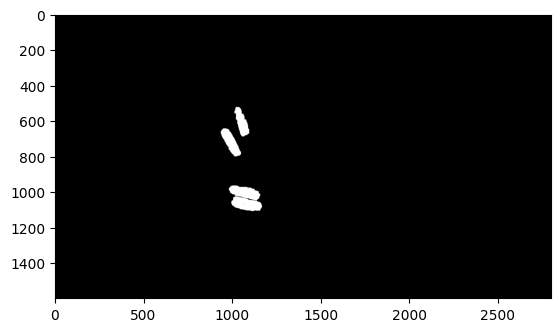

In [ ]:
aa = aaa.copy()
# just_pills[~np.isin(labels2, list(filtered_dct.keys()))] = 0
aa[~np.isin(labels, list(filtered_dct.keys()))] = 0
aa = cv2.morphologyEx(aa, cv2.MORPH_OPEN, np.ones((3, 3), np.uint8), iterations = 5)
plt.imshow(aa, cmap = 'gray')

In [ ]:
e, xx = cv2.connectedComponents(aa, connectivity = 4)
e

5